In [1]:
# Import statement
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import re

from tqdm import tqdm
import os
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

2023-04-26 19:25:42.409586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 19:25:47.684885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-26 19:25:47.685152: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-26 19:25:47.685165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Load data
newsgroups_train = fetch_20newsgroups(subset='all', shuffle=True)
X_train = newsgroups_train.data
y_train = newsgroups_train.target

In [3]:
# Cleaning the data
all_punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
all_punctuations = [token for token in all_punctuations]
STOP_WORDS = list(STOP_WORDS) + all_punctuations + ['\n', '<UNK>', '<ALPHANUM>', '<NUM>']
nlp = English()
tokenizer = nlp.tokenizer
X_train = [[token.text.lower() for token in tokenizer(doc)] for doc in X_train]

# Replacing different kinds of tokens with appropriate tokens
for i, doc in enumerate(X_train):
    for j, token in enumerate(doc):
        # legal alphabetic tokens
        if token.isalpha():
            doc[j] = token
        # replace numbers with <NUM>
        elif token.isnumeric():
            doc[j] = '<NUM>'
        # replace alphanumeric tokens with <ALPHANUM>
        elif token.isalnum():
            doc[j] = '<ALPHANUM>'
        # if punctuation
        elif token in all_punctuations:
            doc[j] = token
        # anything else, replace with <UNK>
        else:
            doc[j] = '<UNK>'
    X_train[i] = ' '.join([j.lower() for j in doc if j not in STOP_WORDS])
    X_train[i] = re.sub(r'\s+', ' ', X_train[i])


In [4]:
# Split training data into train, validation and test data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5)
print(len(X_train), len(X_val), len(X_test))

11307 3769 3770


In [5]:
# declaring a model

class Model(nn.Module):
    def __init__(self, vocab_size, num_labels=20):
        super(Model, self).__init__()
        self.vocab_size = vocab_size
        self.num_labels = num_labels
        self.lin1 = nn.Linear(vocab_size, 2048)
        self.final = nn.Linear(2048, num_labels)
    def forward(self, x):
        x = F.relu(self.lin1(x))
        return F.softmax(self.final(x))

In [6]:
# Get the total number of labels in the data
num_labels = len(set(y_train))
print(num_labels)

20


In [7]:
# creat BoW Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print(X_train.toarray().shape, X_val.toarray().shape, X_test.toarray().shape)

(11307, 10000) (3769, 10000) (3770, 10000)


In [8]:
# get vocab size for 
vocab_size = len(vectorizer.vocabulary_)
print(vocab_size)

10000


In [9]:
# initialize the pytorch model and other parameters for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Model(vocab_size, num_labels).to(device)
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = 0.1)
EPOCHS = 5
batch_size = 256

In [10]:
# Dataset and Dataloader classes
class NewsData(Dataset):
    def __init__(self, x, y, num_labels=20):
        self.x = torch.Tensor(x.toarray())
        self.y = torch.Tensor([np.eye(num_labels)[int(i)] for i in y])#.long()
        self.m = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.m
    

dataset_train = NewsData(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = NewsData(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = NewsData(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_343/1432595945.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.y = torch.Tensor([np.eye(num_labels)[int(i)] for i in y])#.long()


In [11]:
# Train function
def train(dataloader, model, loss_function, optimizer, EPOCHS):
    model.train()
    losses = []
    for epoch in range(EPOCHS):
        epoch_losses = []
        for i, (inputs, labels) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)      
#             print(inputs.shape)
            labels = labels.to(device)
#             print(labels)
            
            model.zero_grad()
            optimizer.zero_grad()
            
            y_hat = model.forward(inputs)
#             print(y_hat)
            
            loss = loss_function(y_hat.float(), labels)
#             print(loss)

            loss.backward()
            optimizer.step()
            
            losses.append(loss.cpu().detach().numpy())
    return model, losses    

In [12]:
model, losses = train(dataloader_train, model, loss_function, opt, EPOCHS)
torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model.pth'))

0it [00:00, ?it/s]/tmp/ipykernel_343/4067896047.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.final(x))
45it [00:38,  1.17it/s]
45it [00:05,  8.68it/s]
45it [00:05,  8.79it/s]
45it [00:05,  8.70it/s]
45it [00:05,  8.37it/s]


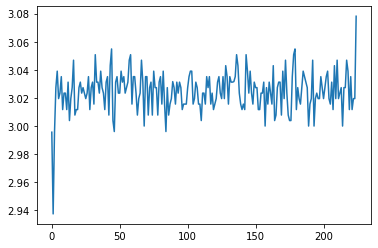

In [13]:
plt.plot(losses)

In [14]:
# Validation function
def validate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, (inputs, labels) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(device)    
        labels = labels.to(device)  
        
        y_hat = model.forward(inputs)
#         print(torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(labels, dim=1)))
#         print(torch.argmax(labels, dim=1))
#         break
        correct += torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(labels, dim=1))
#         print(correct)
        total += inputs.shape[0]
#         print(total)
    print(correct.item()/total)

validate(model, dataloader_val)

0it [00:00, ?it/s]/tmp/ipykernel_343/4067896047.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.final(x))
15it [00:00, 16.98it/s]

0.051737861501724595


In [15]:
# Test function - can reuse validate function
validate(model, dataloader_test)

0it [00:00, ?it/s]/tmp/ipykernel_343/4067896047.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.final(x))
15it [00:00, 27.83it/s]

0.05172413793103448
